In [1]:
# IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

%matplotlib notebook

In [2]:
# READ DATA: Blade landings 

blade_landings= pd.read_csv('blade_landing_helihoist_sbitroot.txt')

# make epoch index of dataframe and convert epoch into readable dates
blade_landings.epoch_land= blade_landings.epoch_land.apply(lambda x: pd.to_datetime(x, unit= 's', utc=True))

# convert blade landings of turbine 8 into readable dates
blade_landing1= pd.to_datetime(1.571127e+09	, unit='s', utc=True)
blade_landing2= pd.to_datetime(1.571154e+09, unit='s', utc=True)
blade_landing3= pd.to_datetime(1.571188e+09, unit='s', utc=True)

In [7]:
# Read csv files of GPS Data: turbine 8

# sbitroot
gps_sbitroot_tb8= pd.read_csv('turbine-08_sbitroot_tom_gps.csv')
gps_sbitroot_tb8.epoch= pd.to_datetime(gps_sbitroot_tb8.epoch, unit= 's', utc=True)
gps_sbitroot_tb8.set_index('epoch', inplace=True)

# sbittip
gps_sbittip_tb8= pd.read_csv('turbine-08_sbittip_tom_gps.csv')
gps_sbittip_tb8.epoch= pd.to_datetime(gps_sbittip_tb8.epoch, unit= 's', utc=True)
gps_sbittip_tb8.set_index('epoch', inplace=True)

# helihoist
gps_helih_tb8= pd.read_csv('turbine-08_helihoist-1_tom_gps.csv')
gps_helih_tb8.epoch= pd.to_datetime(gps_helih_tb8.epoch, unit= 's', utc=True)
gps_helih_tb8.set_index('epoch', inplace=True)

In [8]:
# Find blade installation period in data

hub_height = 90 # hub height = 90m

# smoothing the time series: cut the outliers and find the 20min mean value
hh, sr, st = (gps_helih_tb8.altitude.resample('1s').mean().rolling('20min').mean(), gps_sbitroot_tb8.altitude.resample('1s').mean().rolling('20min').mean(), gps_sbittip_tb8.altitude.resample('1s').mean().rolling('20min').mean())

hh_sbi = hh[(hh > hub_height) & (sr > hub_height) & (st > hub_height)]
sr_sbi = sr[(hh > hub_height) & (sr > hub_height) & (st > hub_height)]
st_sbi = st[(hh > hub_height) & (sr > hub_height) & (st > hub_height)]

# determine start and end period of single blade installations
inst_period = sr_sbi[sr_sbi.index.to_series().diff() > pd.to_timedelta(60, unit='s')].index.to_list()
inst_period.insert(0, sr_sbi.index[0])
inst_period.insert(len(inst_period), sr_sbi.index[-1])
sbi_indices = list()

for i in range(len(inst_period) - 1):
    sbi_indices.append((inst_period[i], hh_sbi[inst_period[i]:inst_period[i+1]].index[-2]))

In [4]:
# FIND FILE 

blade_landing = pd.to_datetime('2019-10-15 07:41', utc=True)

files = glob('turbine-08_sbitroot_tom_acc-vel-pos_2019-10-1*.csv')

for f in files:
    
    f_start = pd.to_datetime(f.split('_')[4], utc=True, format='%Y-%m-%d-%H-%M-%S')
    f_end = pd.to_datetime(f.split('_')[5].split('.')[0], utc=True, format='%Y-%m-%d-%H-%M-%S')
    
    if f_start < blade_landing and f_end > blade_landing:
        print(f'found file: {f}: {f_start}, {f_end}')

found file: turbine-08_sbitroot_tom_acc-vel-pos_2019-10-15-07-40-56_2019-10-15-08-08-20.csv: 2019-10-15 07:40:56+00:00, 2019-10-15 08:08:20+00:00


# SBIT

In [5]:
# READ DATA SBIT

# Blade installation period: landing time
landing1_tb8= pd.read_csv('turbine-08_sbitroot_tom_acc-vel-pos_2019-10-15-08-08-20_2019-10-15-08-36-04.csv')
landing1_tb8.epoch= pd.to_datetime(landing1_tb8.epoch, unit= 's', utc=True)
landing1_tb8.set_index('epoch', inplace=True)

# Blade installation: impact event
imp1_tb8= pd.read_csv('turbine-08_sbitroot_tom_acc-vel-pos_2019-10-15-07-40-56_2019-10-15-08-08-20.csv')
imp1_tb8.epoch= pd.to_datetime(imp1_tb8.epoch, unit= 's', utc=True)
imp1_tb8.set_index('epoch', inplace=True)

# Blade installation period: before landing
inst1_tb8= pd.read_csv('turbine-08_sbitroot_tom_acc-vel-pos_2019-10-15-07-13-34_2019-10-15-07-40-56.csv')
inst1_tb8.epoch= pd.to_datetime(inst1_tb8.epoch, unit= 's', utc=True)
inst1_tb8.set_index('epoch', inplace=True)


<IPython.core.display.Javascript object>


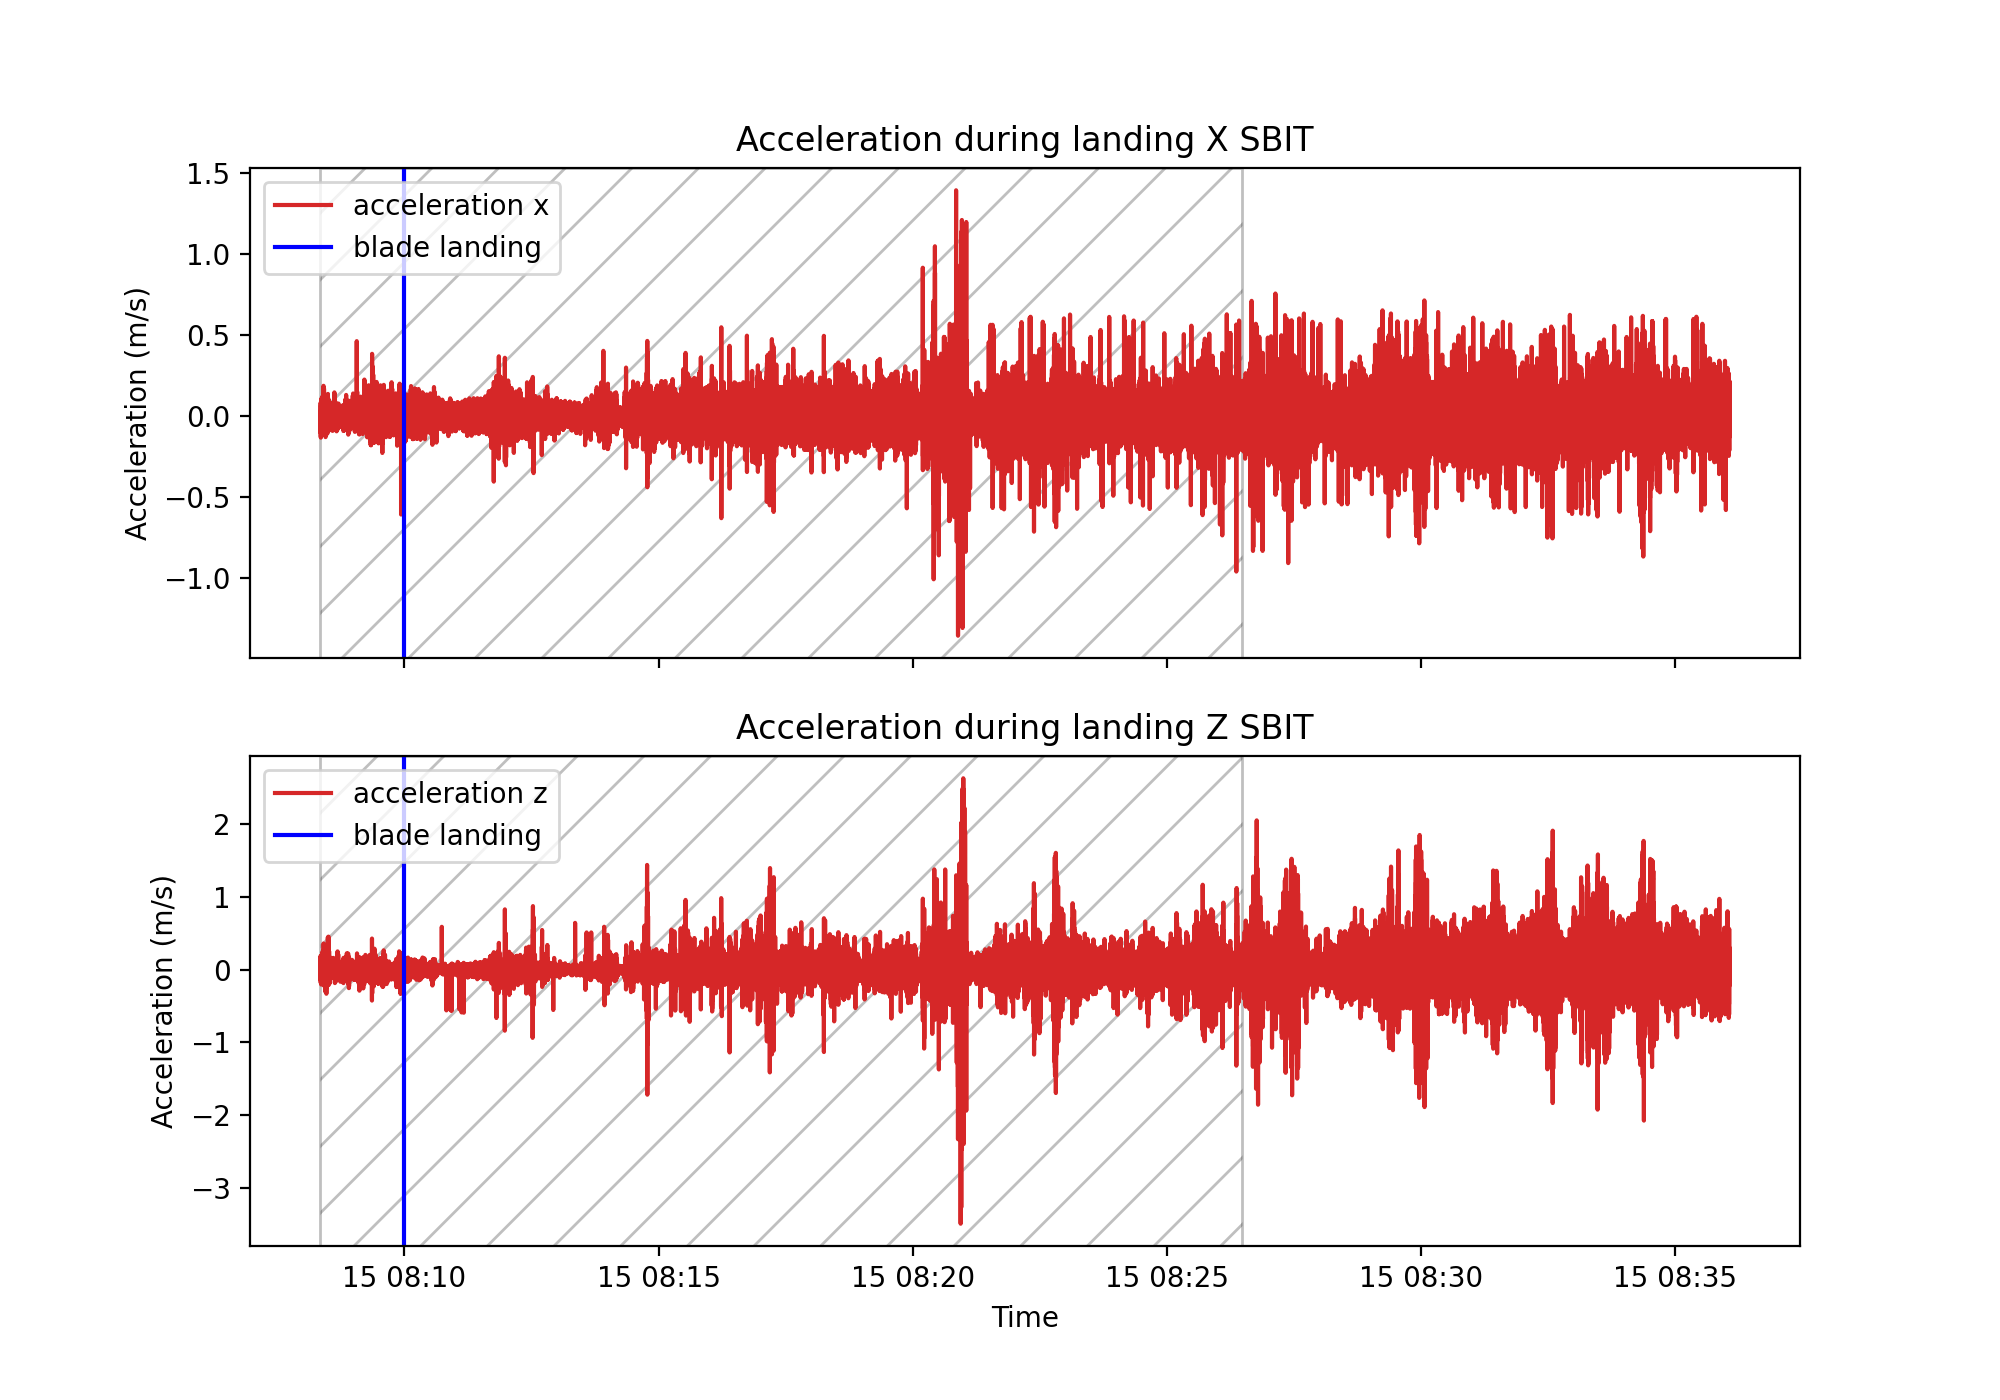

In [59]:
# PLOT BLADE LANDING 1:

fig, axs = plt.subplots(2, sharex=True, figsize= (10,7))
#fig.suptitle('Turbine 08: Blade landing 3')

axs[0].plot(landing1_tb8.acc_x, 'tab:red', label= 'acceleration x')
axs[0].set_title("Acceleration during landing X SBIT")
axs[0].set(ylabel='Acceleration (m/s)')
axs[0].axvline(x=blade_landing1, color='b', label= 'blade landing')
axs[0].axvspan(xmin=landing1_tb8.acc_x.index[0], xmax=sbi_indices[1][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')
axs[0].legend(loc="upper left")

axs[1].plot(landing1_tb8.acc_z, 'tab:red', label='acceleration z')
axs[1].set_title("Acceleration during landing Z SBIT")
axs[1].set(ylabel='Acceleration (m/s)')
axs[1].axvline(x=blade_landing1, color='b', label= 'blade landing')
axs[1].axvspan(xmin=landing1_tb8.acc_x.index[0], xmax=sbi_indices[1][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')
axs[1].legend(loc="upper left")

plt.xlabel('Time')
plt.savefig('tb8_b1_SBIT_acceleration', dpi=300)

<IPython.core.display.Javascript object>


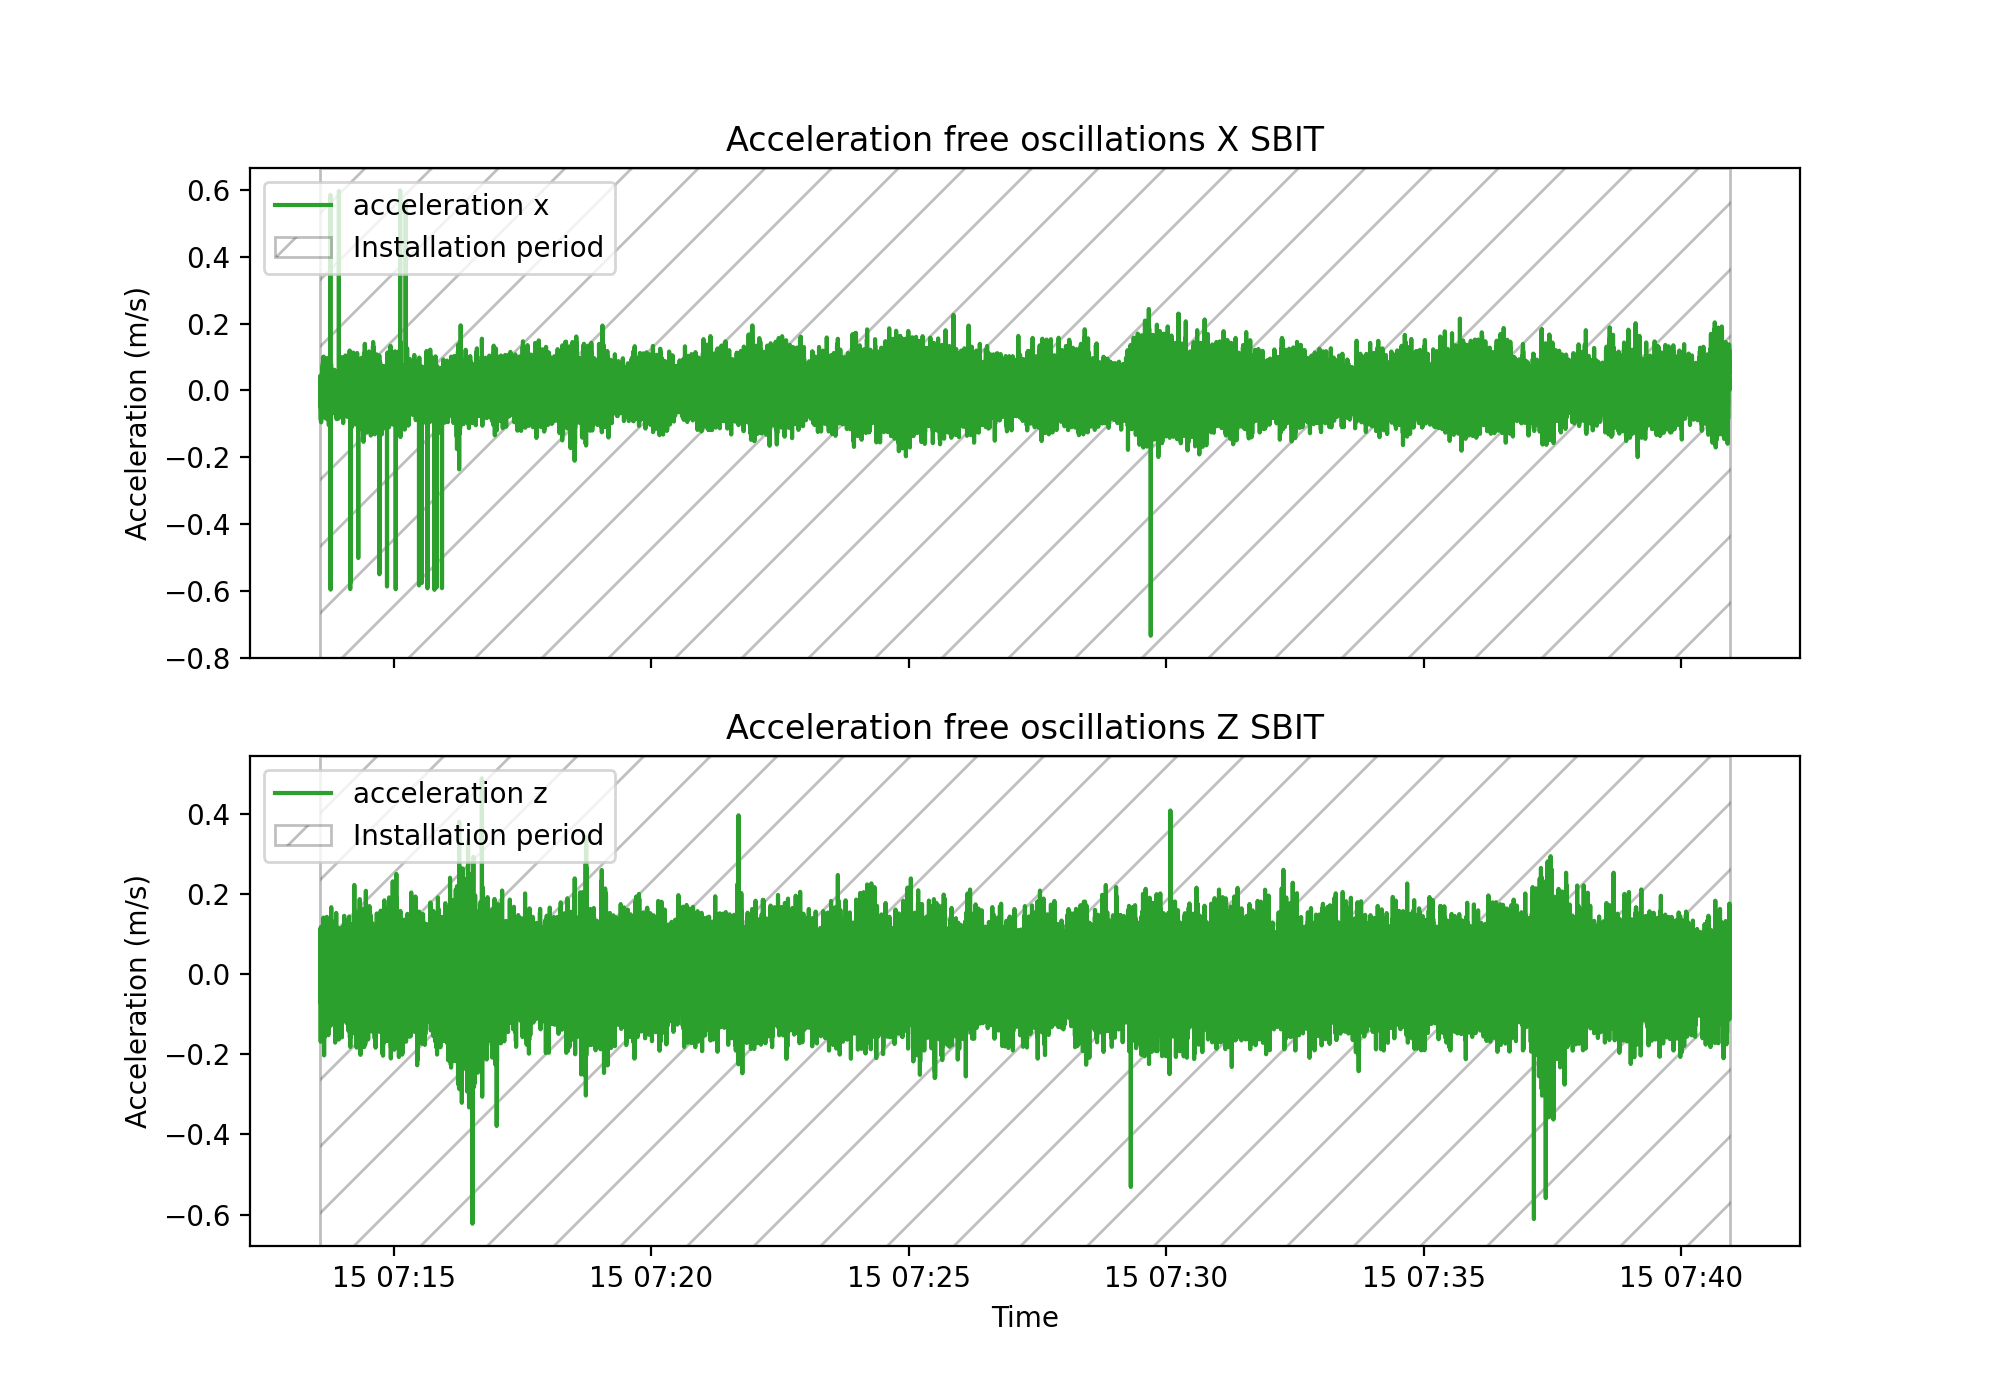

In [60]:
# PLOT BLADE INSTALLATION 1 WITHOUT LANDING:

fig, axs = plt.subplots(2, sharex=True, figsize= (10,7))
#fig.suptitle('Turbine 08: Blade landing 3')

axs[0].plot(inst1_tb8.acc_x, 'tab:green', label= 'acceleration x')
axs[0].set_title("Acceleration free oscillations X SBIT")
axs[0].set(ylabel='Acceleration (m/s)')
axs[0].axvspan(xmin=inst1_tb8.acc_x.index[0], xmax=inst1_tb8.acc_x.index[49754], hatch='/', facecolor='white', alpha=0.25, edgecolor='k', label='Installation period')   
axs[0].legend(loc="upper left")

axs[1].plot(inst1_tb8.acc_z, 'tab:green', label='acceleration z')
axs[1].set_title("Acceleration free oscillations Z SBIT")
axs[1].set(ylabel='Acceleration (m/s)')
axs[1].axvspan(xmin=inst1_tb8.acc_x.index[0], xmax=inst1_tb8.acc_x.index[49754], hatch='/', facecolor='white', alpha=0.25, edgecolor='k', label='Installation period')   
axs[1].legend(loc="upper left")

plt.xlabel('Time')
plt.savefig('tb8_oscillation_SBIT_acceleration', dpi=300)

<IPython.core.display.Javascript object>


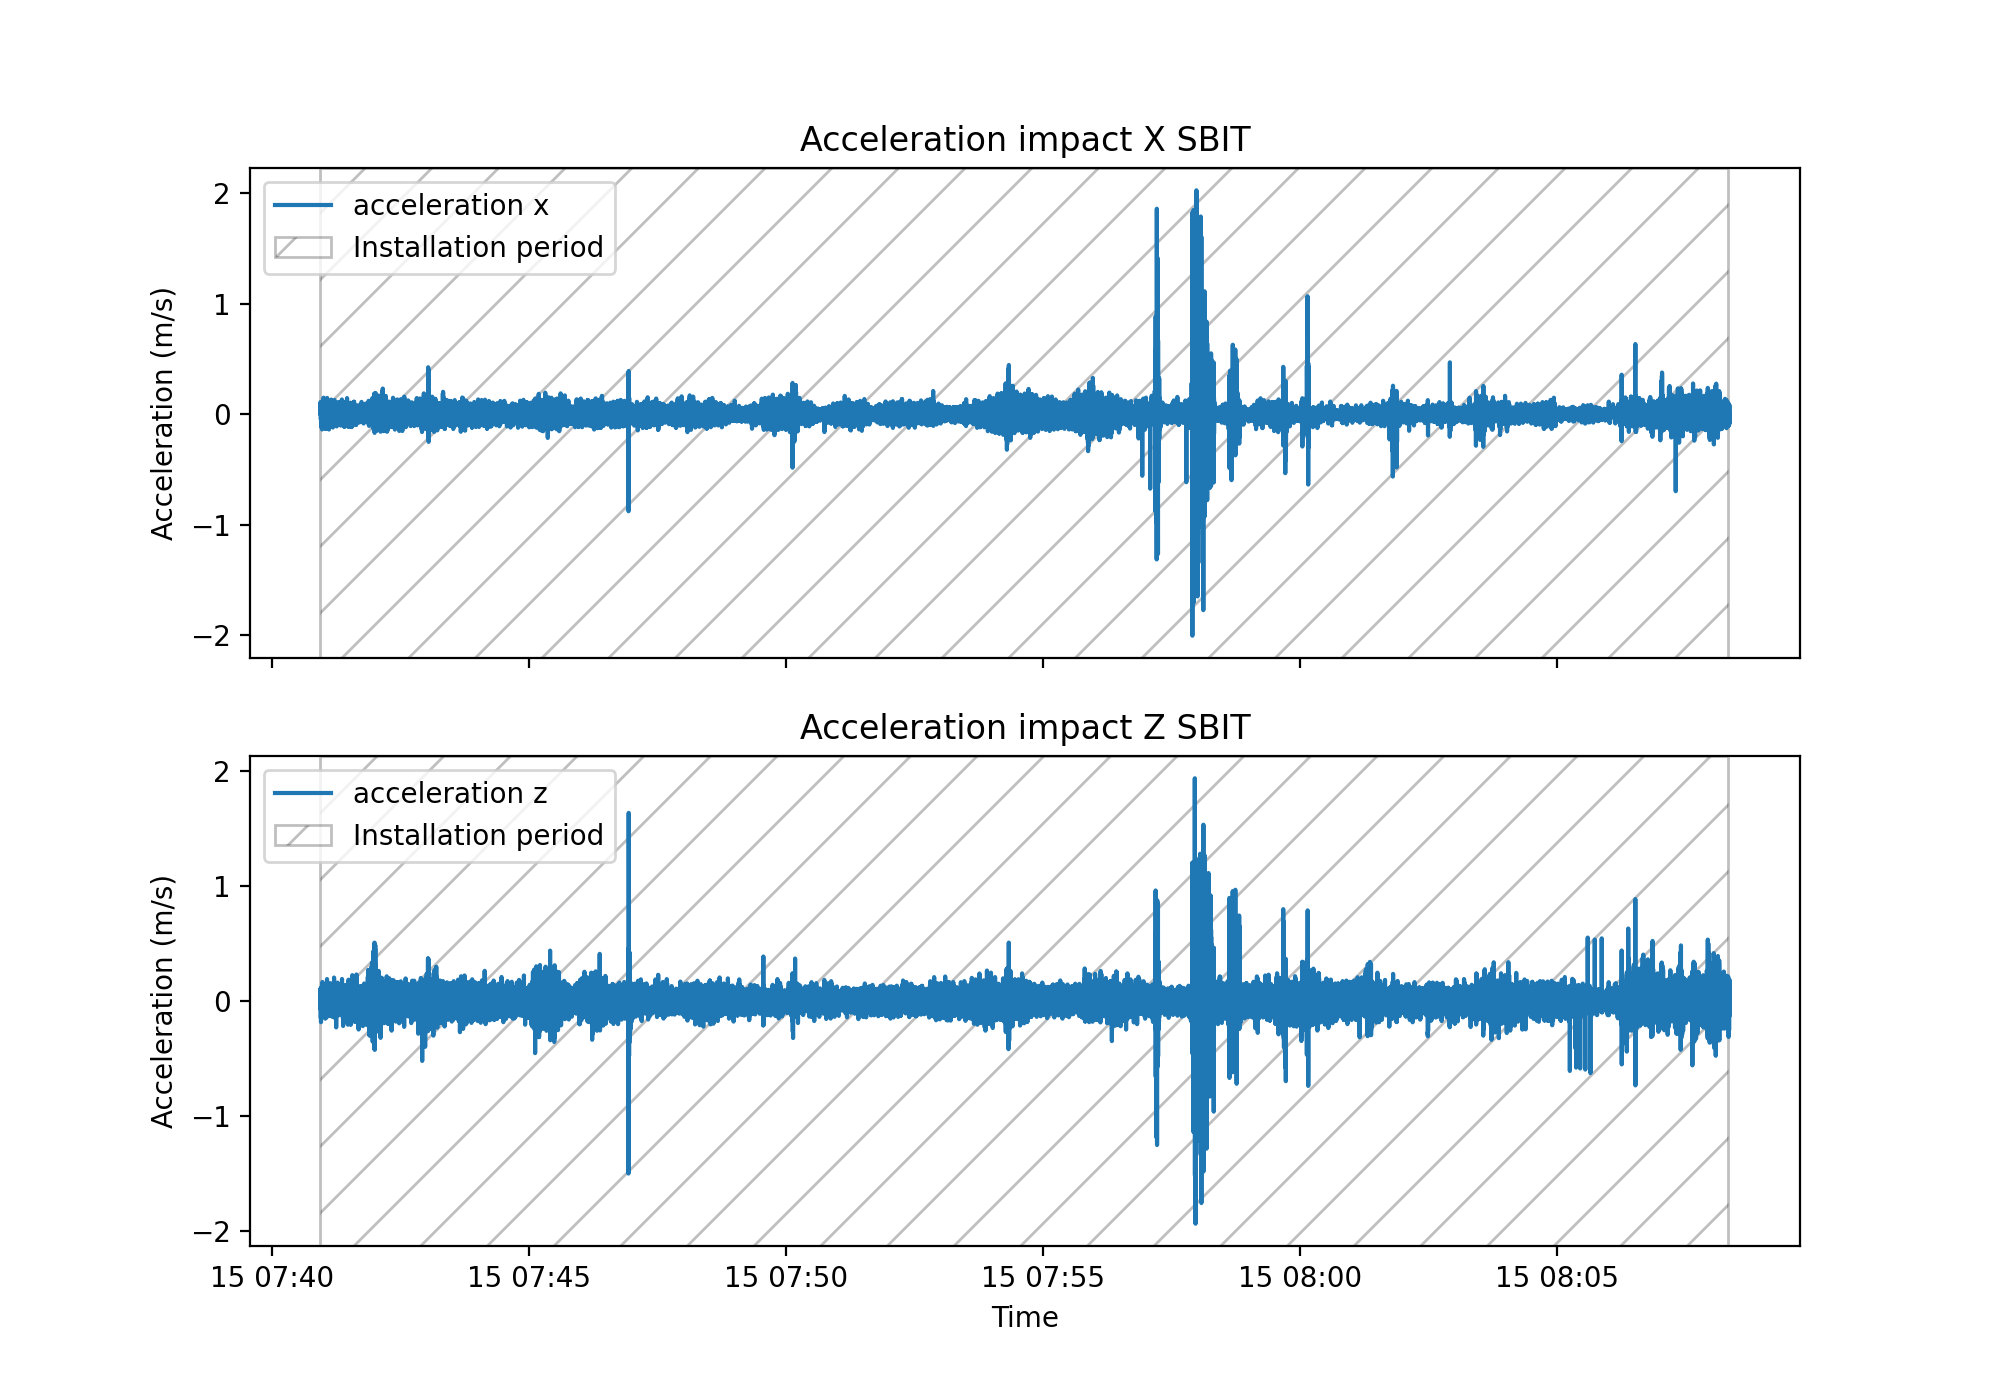

In [61]:
# PLOT IMPACT EVENT:

fig, axs = plt.subplots(2, sharex=True, figsize= (10,7))
#fig.suptitle('Turbine 08: Blade landing 3')

axs[0].plot(imp1_tb8.acc_x, 'tab:blue', label= 'acceleration x')
axs[0].set_title("Acceleration impact X SBIT")
axs[0].set(ylabel='Acceleration (m/s)')
axs[0].axvspan(xmin=imp1_tb8.acc_x.index[0], xmax=imp1_tb8.acc_x.index[49754], hatch='/', facecolor='white', alpha=0.25, edgecolor='k', label='Installation period')   
axs[0].legend(loc="upper left")

axs[1].plot(imp1_tb8.acc_z, 'tab:blue', label='acceleration z')
axs[1].set_title("Acceleration impact Z SBIT")
axs[1].set(ylabel='Acceleration (m/s)')
axs[1].axvspan(xmin=imp1_tb8.acc_x.index[0], xmax=imp1_tb8.acc_x.index[49754], hatch='/', facecolor='white', alpha=0.25, edgecolor='k', label='Installation period')   
axs[1].legend(loc="upper left")

plt.xlabel('Time')
plt.savefig('tb8_impact_SBIT_acceleration', dpi=300)

# Tower

In [31]:
# READ DATA TOWER

# Blade installation period: landing time
tower_landing1_tb8= pd.read_csv('turbine-08_helihoist-1_tom_acc-vel-pos_2019-10-15-07-57-08_2019-10-15-08-23-52.csv')
tower_landing1_tb8.epoch= pd.to_datetime(tower_landing1_tb8.epoch, unit= 's', utc=True)
tower_landing1_tb8.set_index('epoch', inplace=True)

# Blade installation period: impact event
tower_impact_tb8= pd.read_csv('turbine-08_helihoist-1_tom_acc-vel-pos_2019-10-15-07-30-26_2019-10-15-07-57-08.csv')
tower_impact_tb8.epoch= pd.to_datetime(tower_impact_tb8.epoch, unit= 's', utc=True)
tower_impact_tb8.set_index('epoch', inplace=True)

# Blade installation period: before landing
tower_tb8= pd.read_csv('turbine-08_helihoist-1_tom_acc-vel-pos_2019-10-15-07-03-49_2019-10-15-07-30-26.csv')
tower_tb8.epoch= pd.to_datetime(tower_tb8.epoch, unit= 's', utc=True)
tower_tb8.set_index('epoch', inplace=True)

<IPython.core.display.Javascript object>


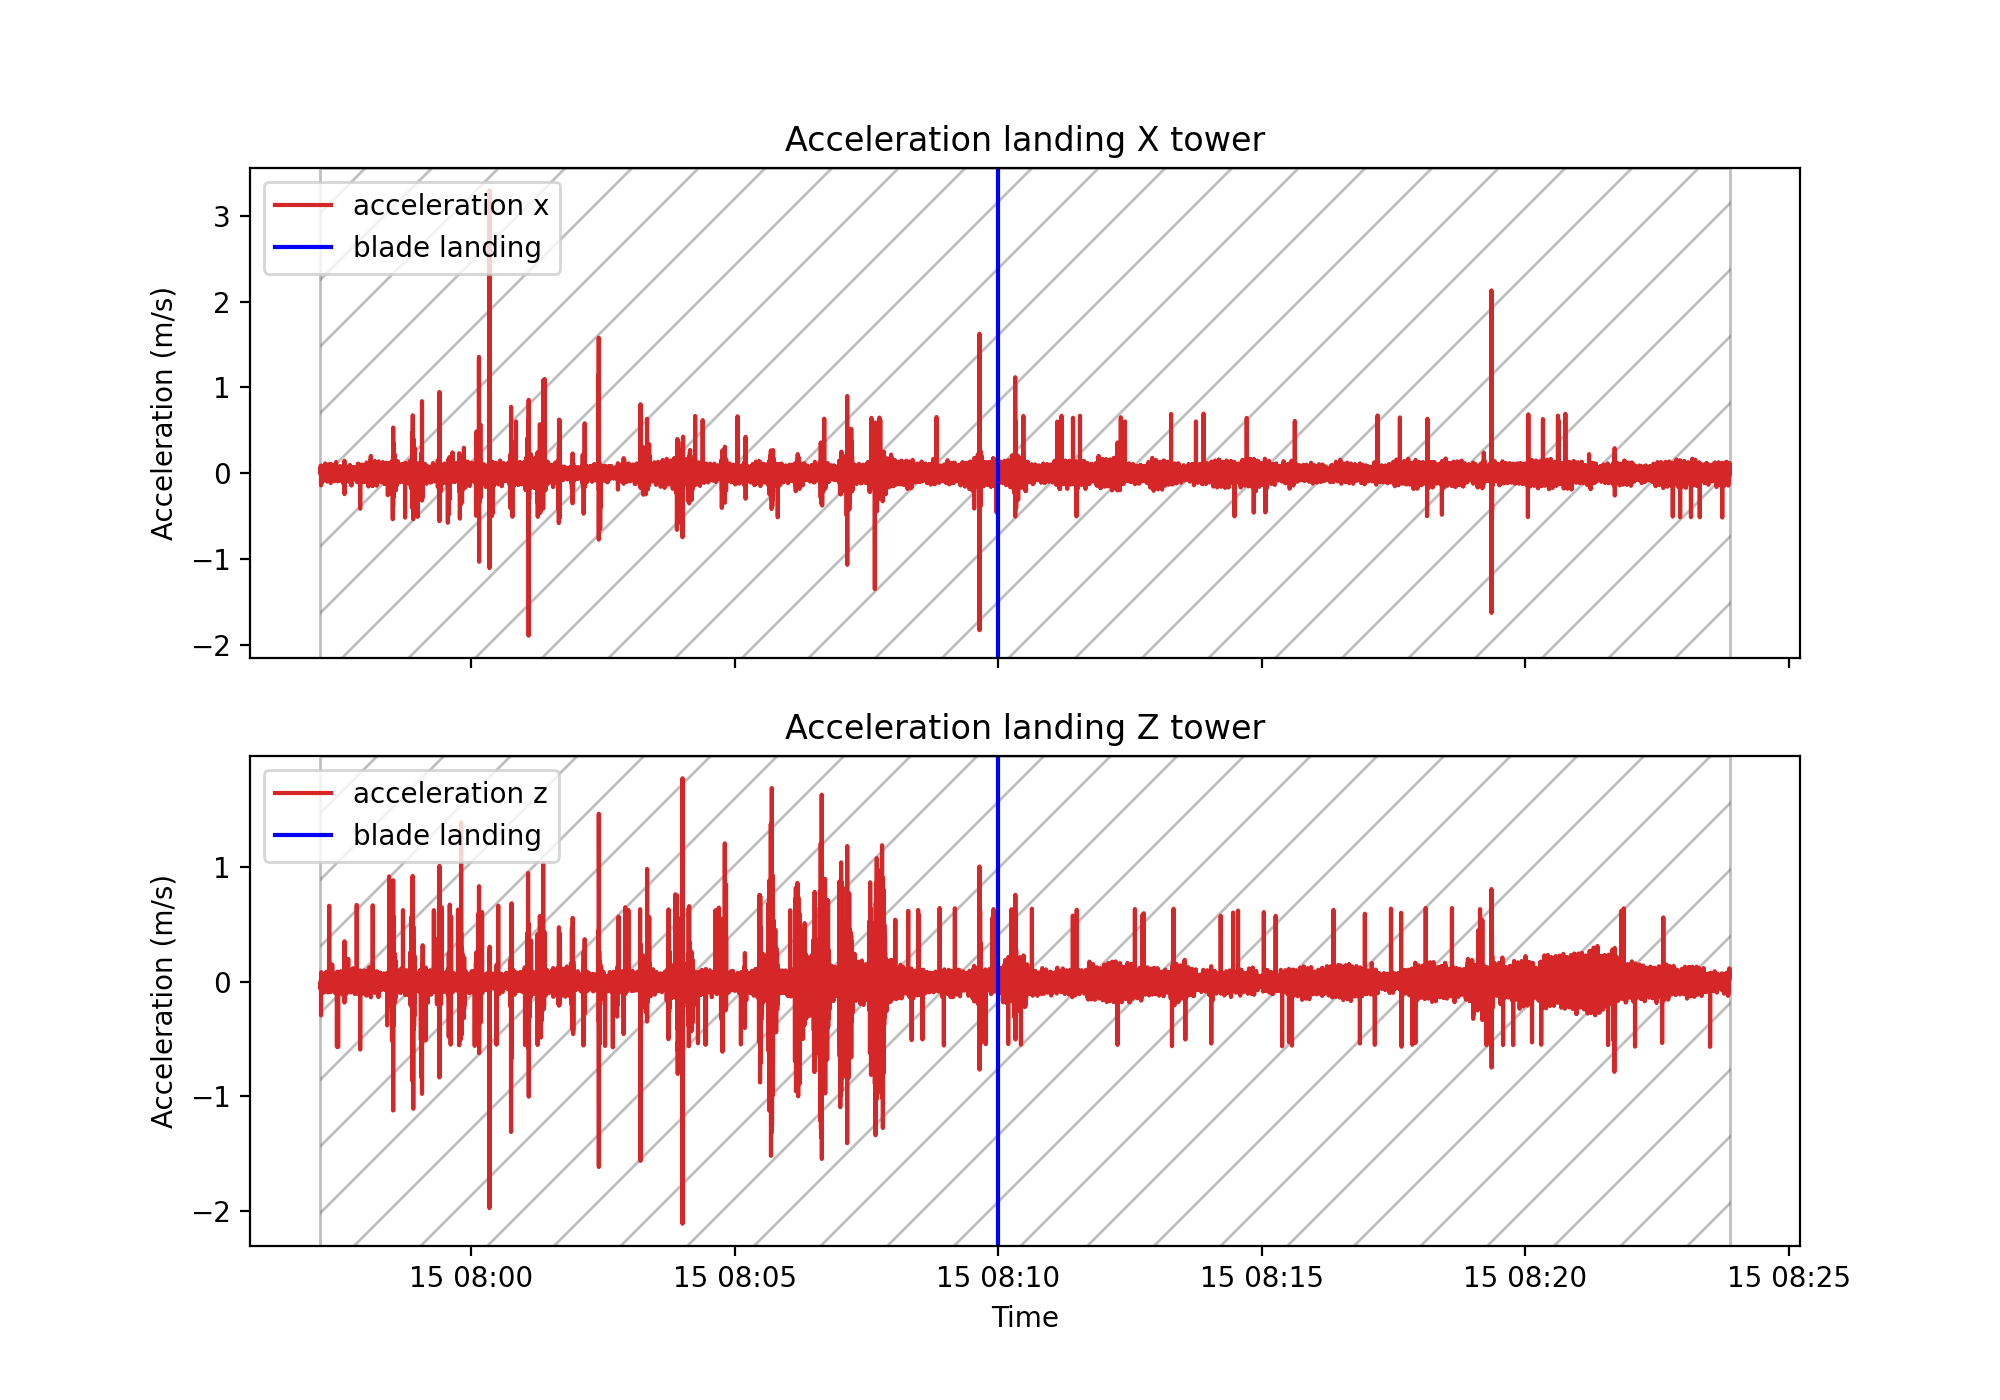

In [62]:
# PLOT BLADE LANDING 1 TOWER:


fig, axs = plt.subplots(2, sharex=True, figsize= (10,7))
#fig.suptitle('Turbine 08: Blade landing 3')

axs[0].plot(tower_landing1_tb8.acc_x, 'tab:red', label= 'acceleration x')
axs[0].set_title("Acceleration landing X tower")
axs[0].set(ylabel='Acceleration (m/s)')
axs[0].axvline(x=blade_landing1, color='b', label= 'blade landing')
axs[0].axvspan(xmin=tower_landing1_tb8.acc_x.index[0], xmax=tower_landing1_tb8.acc_x.index[48597], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')
axs[0].legend(loc="upper left")

axs[1].plot(tower_landing1_tb8.acc_z, 'tab:red', label='acceleration z')
axs[1].set_title("Acceleration landing Z tower")
axs[1].set(ylabel='Acceleration (m/s)')
axs[1].axvline(x=blade_landing1, color='b', label= 'blade landing')
axs[1].axvspan(xmin=tower_landing1_tb8.acc_x.index[0], xmax=tower_landing1_tb8.acc_x.index[48597], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')
axs[1].legend(loc="upper left")

plt.xlabel('Time')
plt.savefig('tb8_tb1_tower_acceleration', dpi=300)

<IPython.core.display.Javascript object>


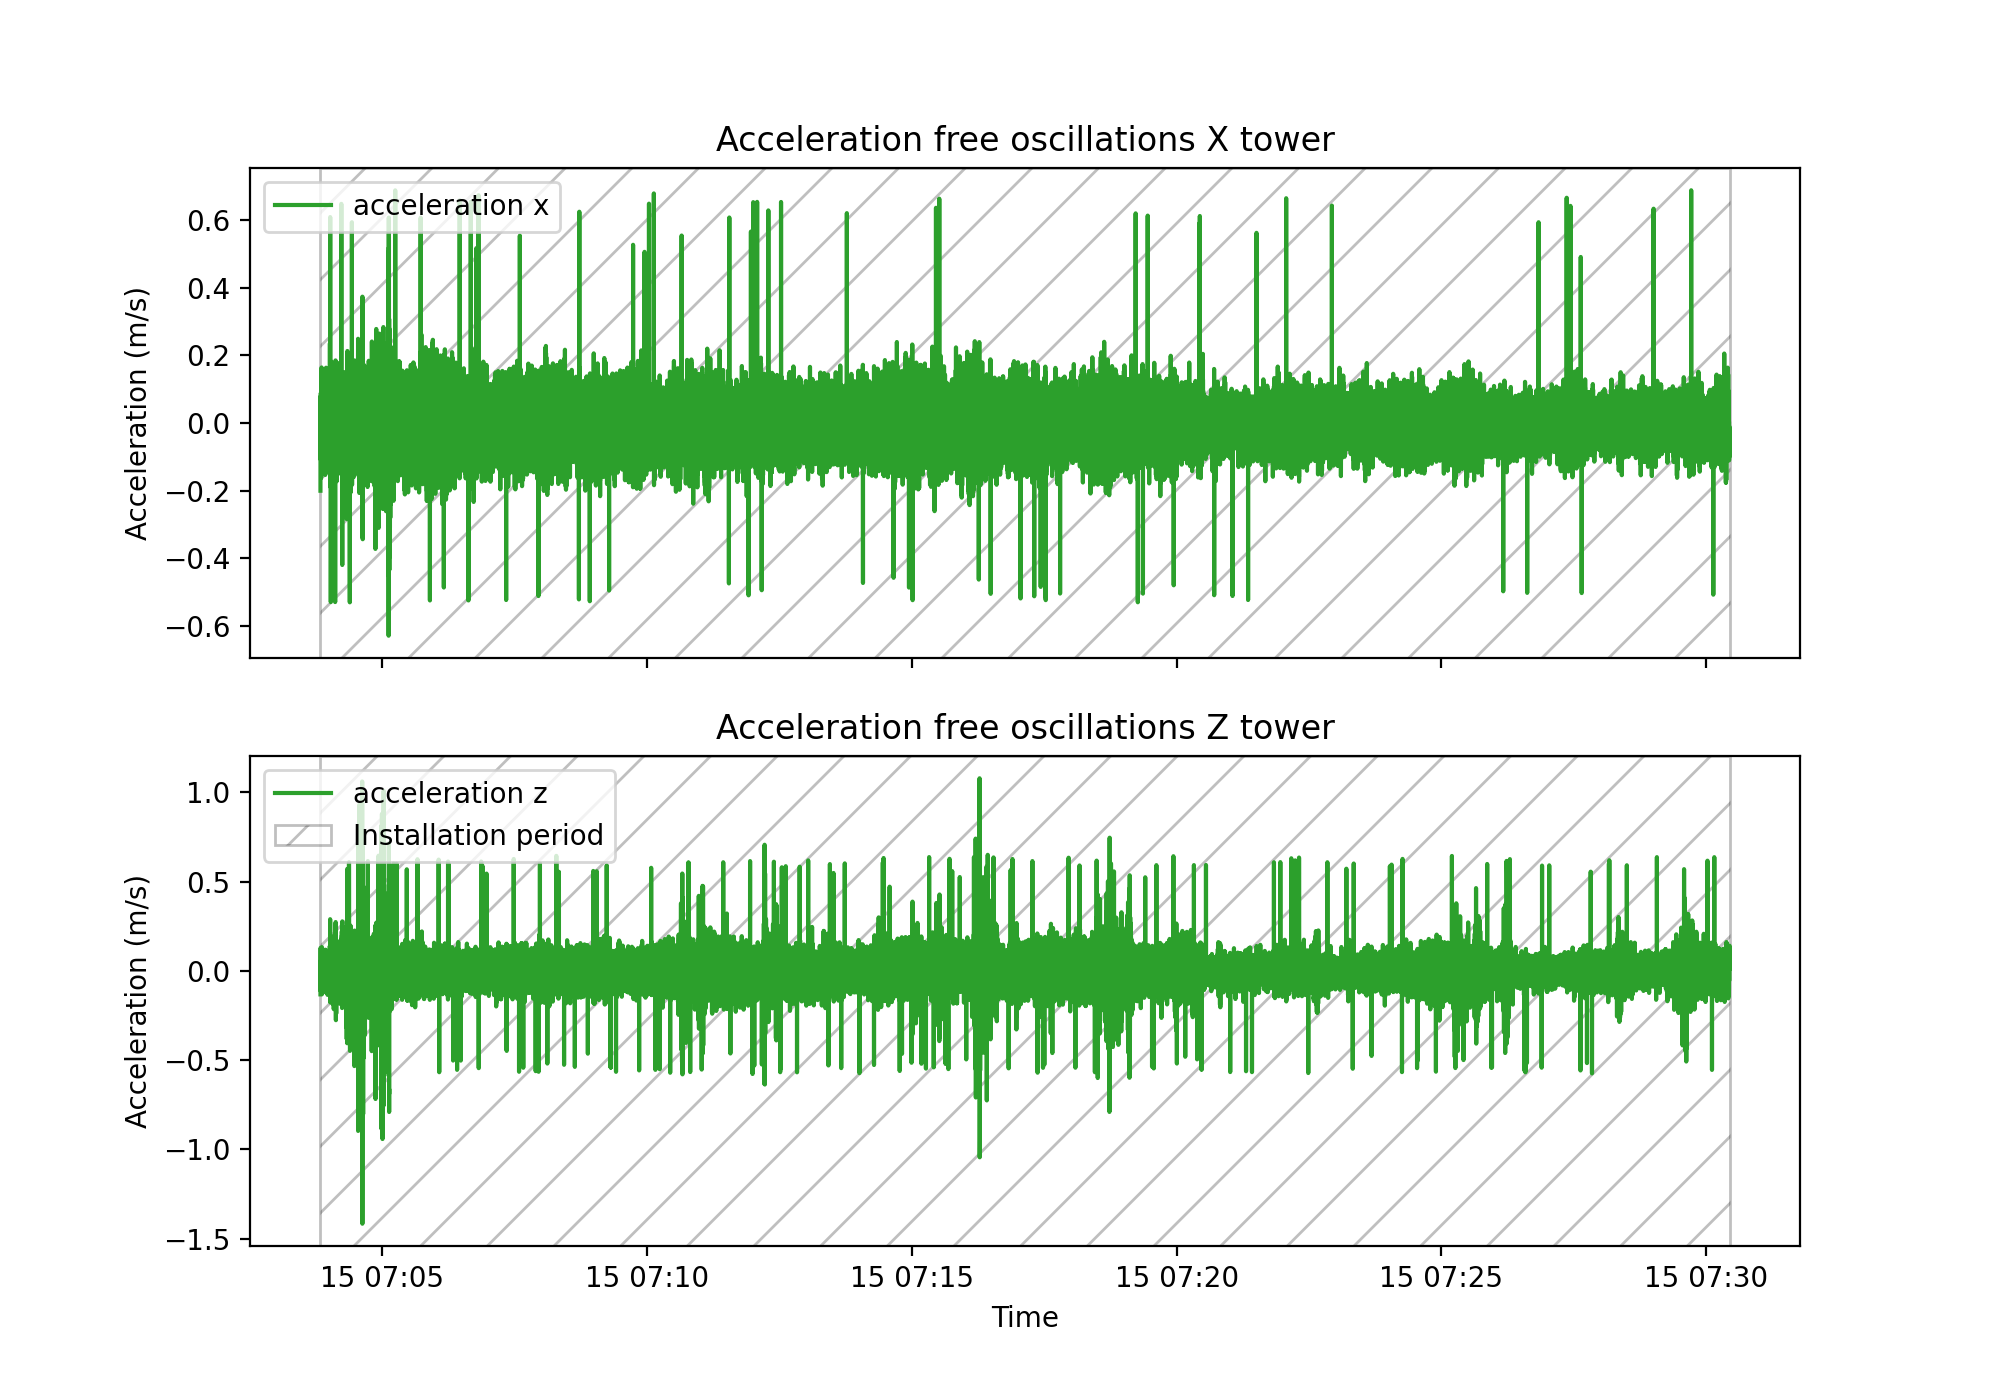

In [63]:
# PLOT INSTALLATION TOWER:

fig, axs = plt.subplots(2, sharex=True, figsize= (10,7))
#fig.suptitle('Turbine 08: Blade landing 3')

axs[0].plot(tower_tb8.acc_x, 'tab:green', label= 'acceleration x')
axs[0].set_title("Acceleration free oscillations X tower")
axs[0].set(ylabel='Acceleration (m/s)')
axs[0].axvspan(xmin=tower_tb8.acc_x.index[0], xmax=tower_tb8.acc_x.index[48390], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')
axs[0].legend(loc="upper left")

axs[1].plot(tower_tb8.acc_z, 'tab:green', label='acceleration z')
axs[1].set_title("Acceleration free oscillations Z tower")
axs[1].set(ylabel='Acceleration (m/s)')
axs[1].axvspan(xmin=tower_tb8.acc_x.index[0], xmax=tower_tb8.acc_x.index[48390], hatch='/', facecolor='white', alpha=0.25, edgecolor='k', label='Installation period')   
axs[1].legend(loc="upper left")

plt.xlabel('Time')
plt.savefig('tb8_oscillation_tower_acceleration', dpi=300)

<IPython.core.display.Javascript object>


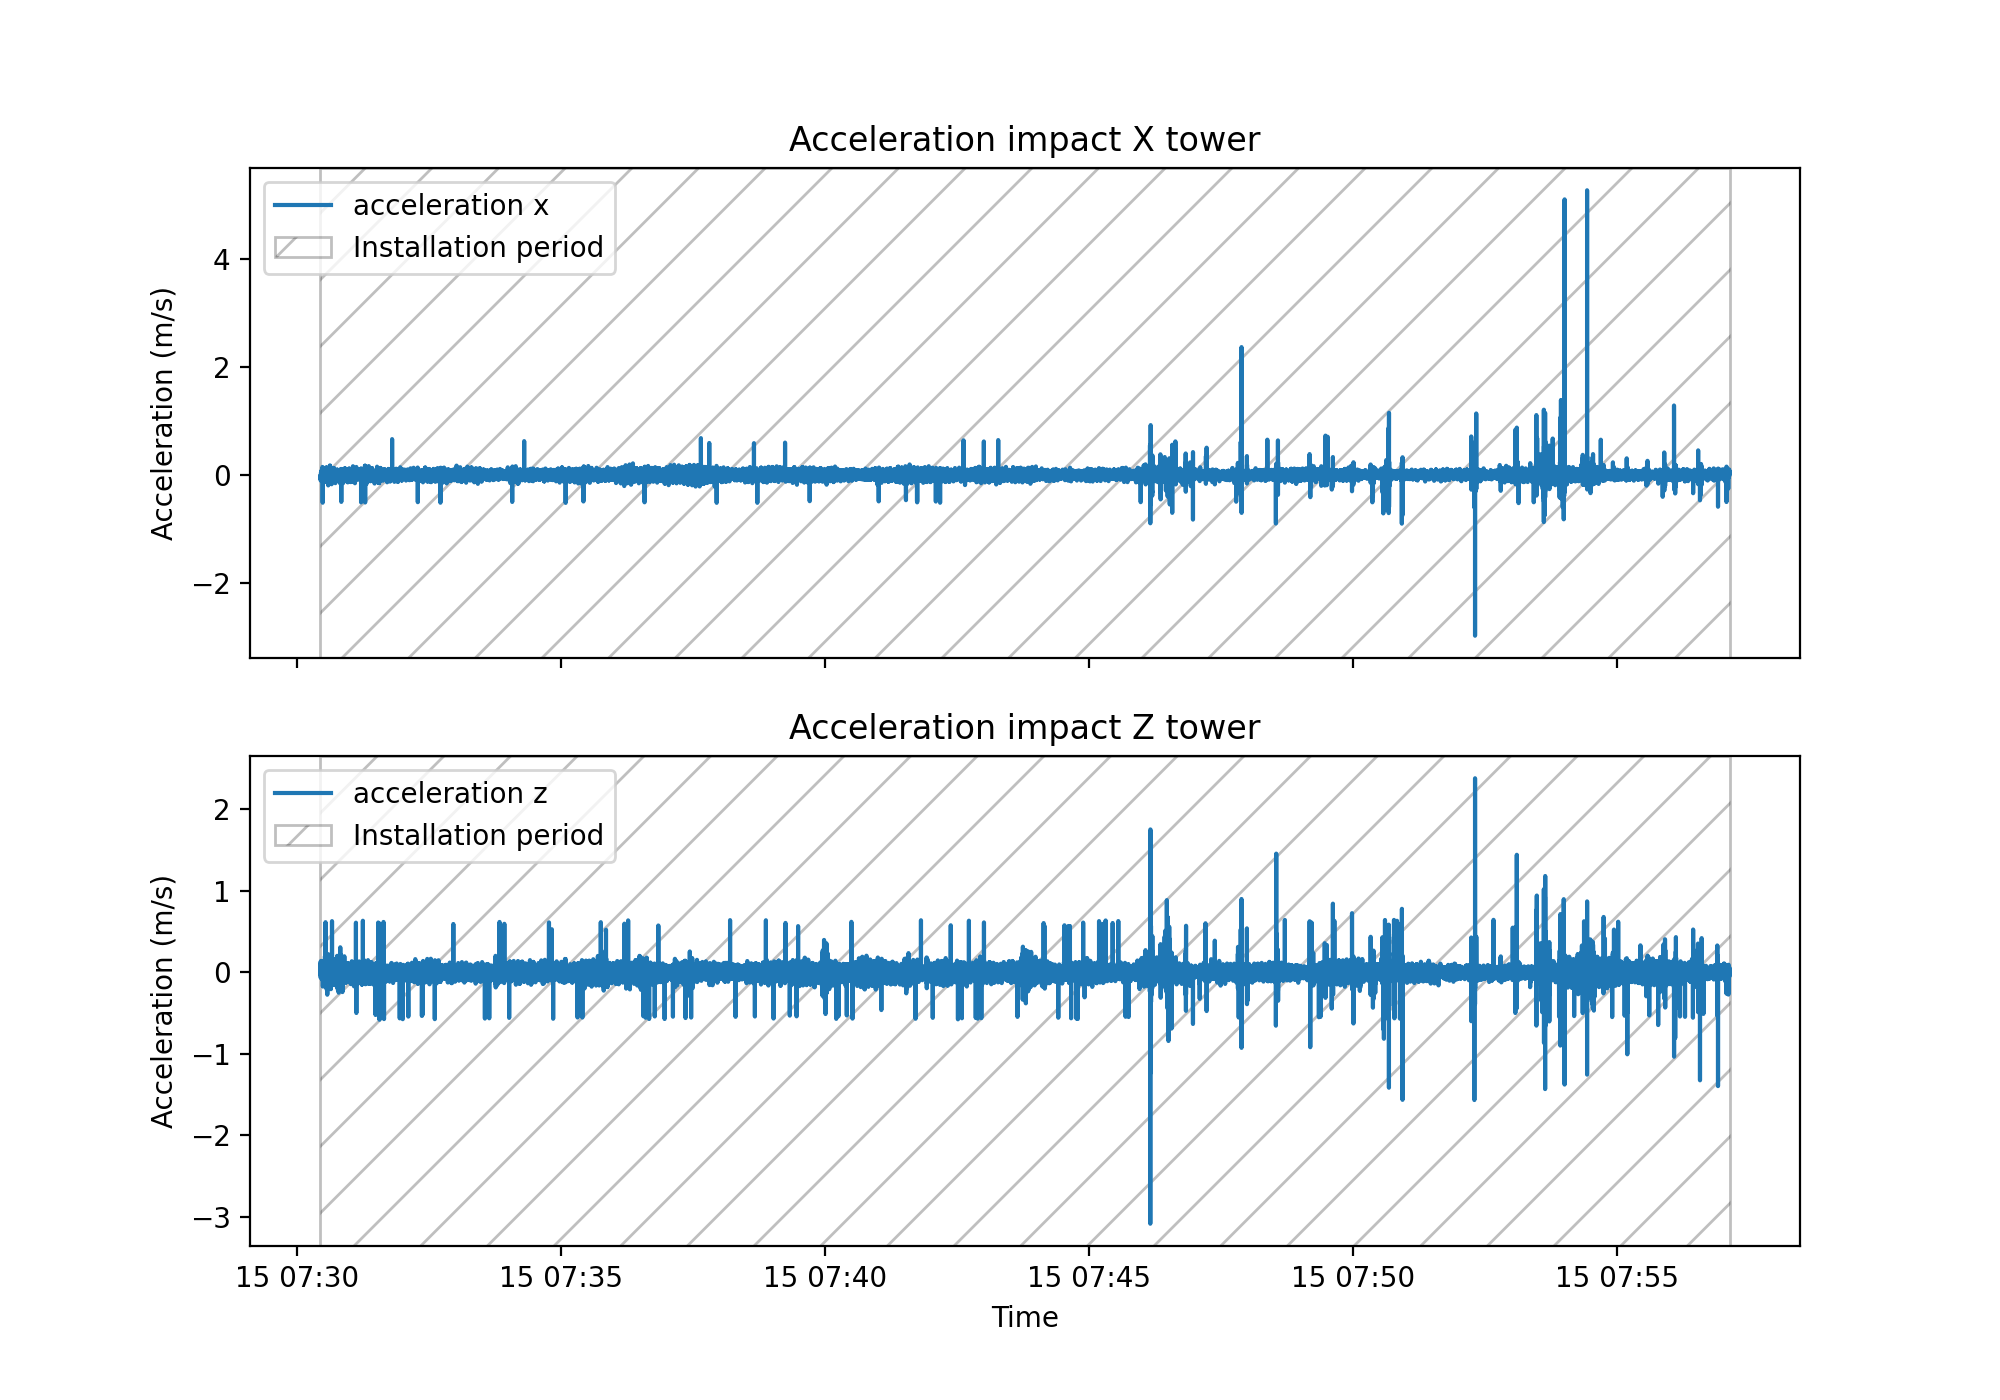

In [64]:
# PLOT IMPACT EVENT TOWER:

fig, axs = plt.subplots(2, sharex=True, figsize= (10,7))
#fig.suptitle('Turbine 08: Blade landing 3')

axs[0].plot(tower_impact_tb8.acc_x, 'tab:blue', label= 'acceleration x')
axs[0].set_title("Acceleration impact X tower")
axs[0].set(ylabel='Acceleration (m/s)')
axs[0].axvspan(xmin=tower_impact_tb8.acc_x.index[0], xmax=tower_impact_tb8.acc_x.index[48535], hatch='/', facecolor='white', alpha=0.25, edgecolor='k', label='Installation period')   
axs[0].legend(loc="upper left")

axs[1].plot(tower_impact_tb8.acc_z, 'tab:blue', label='acceleration z')
axs[1].set_title("Acceleration impact Z tower")
axs[1].set(ylabel='Acceleration (m/s)')
axs[1].axvspan(xmin=tower_impact_tb8.acc_x.index[0], xmax=tower_impact_tb8.acc_x.index[48535], hatch='/', facecolor='white', alpha=0.25, edgecolor='k', label='Installation period')   
axs[1].legend(loc="upper left")

plt.xlabel('Time')
plt.savefig('tb8_impact_tower_acceleration', dpi=300)